# Setup

## Effect of blooming bacteria on Bray-Curtis distance
### Supplementary figure 1

In this Notebook, we test the effect of removing bloom sequences and the impact in beta diversity as measured by Bray Curtis distance. Specifically, we:

1. Load the study datasets (Qiita IDs: W, X, Y, Z) ### TODO, put the IDs in
2. For an increasing number of bloom sequences (starting with zero blooms, and sorted by decreasing severity):
    1. Filter out the bloom sequences
    2. Rarefy to 1000 sequences per sample
    3. Randomly select 1000 samples from each study (with replacement)
    4. Calculate the Bray-Curtis distance for:
        - American Gut vs. Personal Genome Project
        - American Gut vs. Twins UK
        - Twins UK vs. Personal Genome Project
        - Whole Grain Feces vs. Twins UK
3. Plot the result.

Our expectation is that the filtering will reduce distances between the American Gut (room temperature shipping) vs. fresh-frozen studies, while the distances between fresh-frozen studies will change comparably less. The expectation is based on the assumption that the blooms have a higher impact on the American Gut data.

In [1]:
# plots inside the notebook
%matplotlib notebook

# load modules used in the analysis
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import biom
import pandas as pd
import skbio
from scipy.spatial.distance import braycurtis

In [2]:
def load(table_path, metadata_path):
    """Load a study, filter to fecal, drop samples with < 1000 reads"""
    ### TODO: source metadata from qiita so that its normalized
    # different categories and values are used. Not ideal, working around
    sniff = open(metadata_path).read().strip().split('\t')
    if 'ENV_MATTER' in sniff:
        key = 'ENV_MATTER'
        value = 'ENVO:feces'
    elif 'env_matter' in sniff:
        key = 'env_matter'
        value = 'ENVO:feces'
    elif 'env_material' in sniff:
        key = 'env_material'
        value = 'feces'
    else:
        raise KeyError("No interpretable column for denoting fecal")
      
    table = biom.load_table(table_path)
    table.filter(lambda v, i, md: v.sum() > 0)  # drop samples without data
    
    # load metadata, set the index to the samples
    metadata = pd.read_csv(metadata_path, sep='\t', dtype=object, usecols=['#SampleID', key])
    metadata.set_index('#SampleID', inplace=True)
   
    # verify we have information about all samples
    assert set(table.ids()).issubset(metadata.index)
    
    # reduce to the fecal subset
    fecal_metadata = metadata[metadata[key] == value]
    fecal_metadata = fecal_metadata.loc[set(fecal_metadata.index) & set(table.ids())]
    
    # subset to fecal, keep samples with >= 1000 reads, and remove any empty OTUs
    table.filter(fecal_metadata.index)
    table.filter(lambda v, i, md: v.sum() >= 1000)
    table.filter(lambda v, i, md: v.sum() > 0, axis='observation')
    
    # reduce the metadata to only the samples represented
    fecal_metadata = fecal_metadata.loc[table.ids()]
    
    # normalize metadata (we already filtered to fecal based on study specific values)
    fecal_metadata.columns = ['ENV_MATTER']
    fecal_metadata['ENV_MATTER'] = 'feces'
    
    print("Fecal samples: %d" % len(table.ids()))
    
    return table, fecal_metadata

# Loading all experimental data

In [70]:
# TODO: RENAME TO USE QIITA IDS IN THE FILENAMES

ag_table, ag_metadata       = load('../data/ag-6-2016.clean.min100.withtax.biom', '../data/map.ag-6-2016.txt')
twins_table, twins_metadata = load('../data/twins2.clean.min10.withtax.biom','../data/map.twins2.txt')
pgp_table, pgp_metadata     = load('../data/pgp.baylor.clean.withtax.biom','../data/map.pgp.txt')
erc_table, erc_metadata     = load('../data/ercolini.feces.clean.withtax.biom','../data/map.ercolini.txt')

Fecal samples: 7073
Fecal samples: 1017
Fecal samples: 82
Fecal samples: 88


## Join all data into a single table and data frame


In [14]:
table = pgp_table.merge(erc_table).merge(twins_table).merge(ag_table)
metadata = pd.concat([pgp_metadata, erc_metadata, twins_metadata, ag_metadata])

assert set(table.ids()).issubset(metadata.index)
assert len(table.ids()) == len(metadata)

print("Total number of sOTUs: %d\nTotal number of samples: %d" % table.shape)

Total number of sOTUs: 17357
Total number of samples: 8260


## Calculate the mean Bray-Curtis distance for filtering levels

Remove incrementally more blooms, starting from the most severe to least severe, and at each increment, compute the Bray Curtis distance between random sets of samples within each study.

In [67]:
def sample_and_remap(df, iterations, index, tag):
    """Sample with replacement from df, return the observed index positions"""
    # determine what IDs are still in the table
    valid = set(index).intersection(df.index)
    
    # randomly sample with replacement over the IDs
    ids = df.loc[valid].sample(iterations, replace=True).index.values
    
    # determine their index position in the matrix
    indices = [index[i] for i in ids]
    
    if len(df) - len(valid):
        print("  %s - %d sample(s) did not pass filtering" % (tag, len(df) - len(valid)))

    return indices 

# initial conditions
iterations = 1000
sequences = list(skbio.read('../data/newbloom.all.fa', format='fasta'))

# datasets to store the resulting bray curtis distances
ag_vs_twin  = np.zeros((len(sequences) + 1, iterations))
ag_vs_pgp   = np.zeros((len(sequences) + 1, iterations))
pgp_vs_twin = np.zeros((len(sequences) + 1, iterations))
erc_vs_twin = np.zeros((len(sequences) + 1, iterations))

blooms = set()
for bloom_idx in range(len(sequences) + 1):
    # make sure we run once without any blooms
    if bloom_idx > 0:
        blooms.add(str(sequences[bloom_idx - 1]))
        
    print("Operating on %d bloom(s)..." % len(blooms))
    
    # remove bloom sequences, rarefy, normalize to [0, 1], and fetch a dense representation
    table_wo_blooms = table.filter(blooms, invert=True, inplace=False, axis='observation')
    table_wo_blooms = table_wo_blooms.subsample(1000).norm()
    table_wo_blooms_mat = table_wo_blooms.matrix_data.T.toarray()
    
    # compute an index mapping each ID to a row in the matrix
    index = {i: idx for idx, i in enumerate(table_wo_blooms.ids())}
    
    # get a bunch of random positions in the matrix for each study
    ag_samples    = sample_and_remap(ag_metadata, iterations, index, 'AG') 
    pgp_samples   = sample_and_remap(pgp_metadata, iterations, index, 'PGP')
    erc_samples   = sample_and_remap(erc_metadata, iterations, index, 'ERC')
    twins_samples = sample_and_remap(twins_metadata, iterations, index, 'Twins')
    
    # pull out the matrix of counts corresponding to the random positions
    ag_counts    = table_wo_blooms_mat[ag_samples]
    pgp_counts   = table_wo_blooms_mat[pgp_samples]
    erc_counts   = table_wo_blooms_mat[erc_samples]
    twins_counts = table_wo_blooms_mat[twins_samples]
    
    # compute bray curtis
    ag_vs_twin[bloom_idx]  = np.array([braycurtis(u, v) for u, v in zip(ag_counts, twins_counts)])
    ag_vs_pgp[bloom_idx]   = np.array([braycurtis(u, v) for u, v in zip(ag_counts, pgp_counts)])
    pgp_vs_twin[bloom_idx] = np.array([braycurtis(u, v) for u, v in zip(pgp_counts, twins_counts)])
    erc_vs_twin[bloom_idx] = np.array([braycurtis(u, v) for u, v in zip(erc_counts, twins_counts)])

Operating on 0 bloom(s)...
Operating on 1 bloom(s)...
	AG - 3 samples did not pass filtering
Operating on 2 bloom(s)...
	AG - 6 samples did not pass filtering
Operating on 3 bloom(s)...
	AG - 7 samples did not pass filtering
Operating on 4 bloom(s)...
	AG - 11 samples did not pass filtering
Operating on 5 bloom(s)...
	AG - 75 samples did not pass filtering
Operating on 6 bloom(s)...
	AG - 78 samples did not pass filtering
Operating on 7 bloom(s)...
	AG - 78 samples did not pass filtering
Operating on 8 bloom(s)...
	AG - 102 samples did not pass filtering
Operating on 9 bloom(s)...
	AG - 109 samples did not pass filtering
Operating on 10 bloom(s)...
	AG - 117 samples did not pass filtering
Operating on 11 bloom(s)...
	AG - 117 samples did not pass filtering
Operating on 12 bloom(s)...
	AG - 117 samples did not pass filtering
Operating on 13 bloom(s)...
	AG - 122 samples did not pass filtering
Operating on 14 bloom(s)...
	AG - 126 samples did not pass filtering
Operating on 15 bloom(s)..

<IPython.core.display.Javascript object>


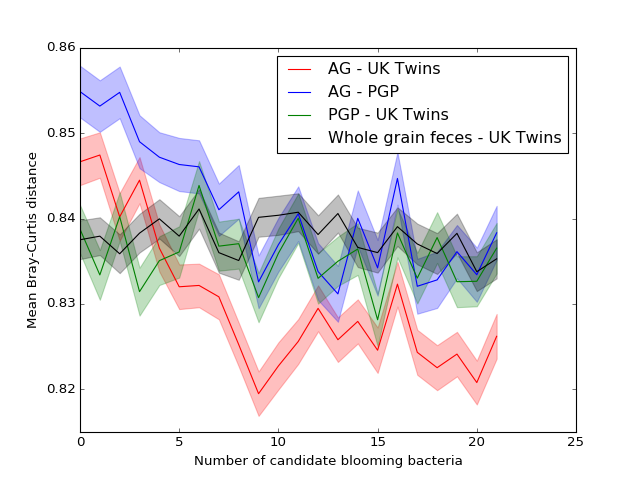

In [69]:
def plot_comparison(results, color):
    """Plot mean and stderr for the values in results"""
    n_blooms, iterations = results.shape
    x_axis = np.arange(n_blooms)
    
    results_mean = results.mean(axis=1)
    results_stderr = results.std(axis=1) / np.sqrt(iterations)
    
    plt.fill_between(x_axis, 
                     results_mean + results_stderr, 
                     results_mean - results_stderr, 
                     alpha=0.25, color=color)
    plt.plot(x_axis, results_mean, color=color)

plt.figure()
plot_comparison(ag_vs_twin, 'r')
plot_comparison(ag_vs_pgp, 'b')
plot_comparison(pgp_vs_twin, 'g')
plot_comparison(erc_vs_twin, 'k')
plt.legend(['AG - UK Twins',
            'AG - PGP',
            'PGP - UK Twins',
            'Whole grain feces - UK Twins'])
plt.xlabel('Number of candidate blooming bacteria')
plt.ylabel('Mean Bray-Curtis distance')